In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from mplsoccer import Pitch, VerticalPitch, Standardizer, add_image, grid_dimensions, grid, FontManager
from matplotlib.colors import LinearSegmentedColormap

In [2]:
p = Pitch(pitch_type='opta', line_zorder=3)
custom_cmap = LinearSegmentedColormap.from_list('greens', ['#edfff2', '#0d773d'], N=100)
custom_cmap_10 = LinearSegmentedColormap.from_list('greens', ['#edfff2', '#0d773d'], N=10)

In [3]:
df = pd.read_parquet('opta_events_112_2022.parquet')
df_match = pd.read_parquet('opta_matches_112_2022.parquet')
# check number of events goals is equal to the total goals in the season
assert (df_match['away_score'] + df_match['home_score']).sum() == (df['type_name'] == 'goal').sum()
df['goal'] = df['type_name'] == 'goal'

In [4]:
df_home = df_match[['match_id', 'home_team_id']].rename({'home_team_id': 'team_id'}, axis='columns').copy()
df_home['home_team'] = True
df = df.merge(df_home, on=['match_id', 'team_id'], how='left')
df['home_team'] = df['home_team'].astype('boolean').fillna(False)
# for own goals reverse so goal is assigned to the other team
df.loc[df['own_goal'], 'home_team'] = ~df.loc[df['own_goal'], 'home_team']
# check that the number of goals for the home and away teams is right over the season
assert df.loc[df['home_team'], 'goal'].sum() == df_match['home_score'].sum()
assert df.loc[~df['home_team'], 'goal'].sum() == df_match['away_score'].sum()

In [5]:
# add on home/away scores to the events at the time of each event
df['home_score'] = df[df['home_team']].groupby('match_id')['goal'].cumsum()
df['away_score'] = df[~df['home_team']].groupby('match_id')['goal'].cumsum()
df['home_score'] = df['home_score'].ffill().bfill().astype('int')
df['away_score'] = df['away_score'].ffill().bfill().astype('int')

In [6]:
# fix x/y locations of penalties so they are in the area
df.loc[df.id == 2469118289, 'y'] = 78.8
df.loc[df.id == 2506568311, 'y'] = 22.1
df.loc[df.id == 2465795915, 'x'] = 85.2
df.loc[df.id == 2465795915, 'y'] = 66.7

In [7]:
df_pen_award = (df[(df.penalty) & (df['type_name'] == 'foul') & (df['duel_events_defensive'].isnull())]
                .dropna(how='all', axis='columns')
                .copy()
               )
df_pen_shot = df[((df.penalty) & (df['type_name'].isin(['goal', 'attempt_saved', 'miss', 'post']))
                 )].copy()
df_pen_award.sort_values('timestamp_utc', inplace=True)
df_pen_shot.sort_values('timestamp_utc', inplace=True)
# check the number of penalty fouls equals the number of penalty shots
assert len(df_pen_award) == len(df_pen_shot)
# check all penalties in the area
mask_check = (df_pen_award.x >= p.dim.penalty_area_right) & (df_pen_award.y >= p.dim.penalty_area_bottom) & (df_pen_award.y <= p.dim.penalty_area_top)
assert mask_check.mean() == 1

In [8]:
df_pen_award_scores = (df_pen_award[['match_id', 'timestamp_utc', 'home_score', 'away_score', 'x', 'y']]
                       .rename({'home_score': 'home_score_before_penalty',
                                'away_score': 'away_score_before_penalty',
                                'x': 'x_foul',
                                'y': 'y_foul'}, axis='columns')
                       .copy()
                      )
df_final_scores = (df_match[['match_id', 'home_score', 'away_score']]
                   .rename({'home_score': 'home_score_final', 'away_score': 'away_score_final'}, axis='columns')
                   .copy()
                  )
df_pen_shot = pd.merge_asof(df_pen_shot, df_pen_award_scores, on='timestamp_utc', by='match_id')
df_pen_shot = df_pen_shot.merge(df_final_scores, on='match_id')

In [9]:
mask_possible_errors = ((df_pen_award['x'] < p.dim.penalty_area_right) | 
                        (df_pen_award['y'] < p.dim.penalty_area_bottom) | 
                        (df_pen_award['y'] > p.dim.penalty_area_top)
                       )

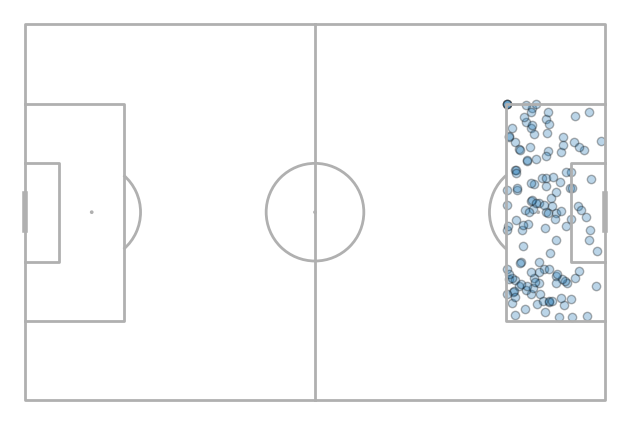

In [10]:
fig, ax = p.draw()
p.scatter(df_pen_award.loc[~mask_possible_errors, 'x'],
          df_pen_award.loc[~mask_possible_errors, 'y'],
          ax=ax, alpha=0.3, ec='black')
p.scatter(df_pen_award.loc[mask_possible_errors, 'x'],
          df_pen_award.loc[mask_possible_errors, 'y'],
          ax=ax,
          color='orange')

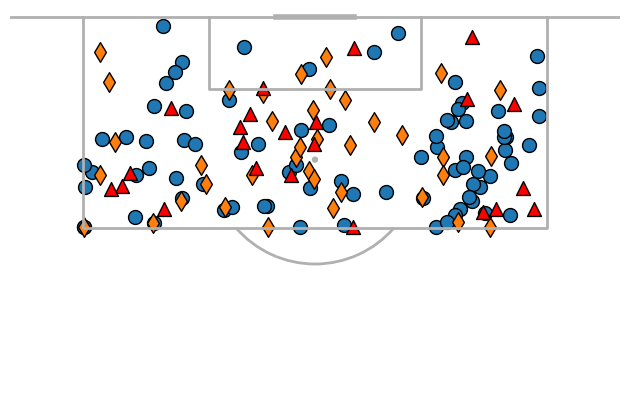

In [11]:
vp = VerticalPitch(pitch_type='opta', line_zorder=2, half=True,
                   pad_left=-12, pad_right=-12, pad_bottom=-31, pad_top=1)
fig, ax = vp.draw()
vp.scatter(df_pen_award.loc[df_pen_award['foul_attempted_tackle'], 'x'],
          df_pen_award.loc[df_pen_award['foul_attempted_tackle'], 'y'],
          ax=ax, alpha=1, ec='black', s=100)
vp.scatter(df_pen_award.loc[df_pen_award['foul_handball'], 'x'],
          df_pen_award.loc[df_pen_award['foul_handball'], 'y'],
          ax=ax, alpha=1, ec='black', marker='d', s=100)
vp.scatter(df_pen_award.loc[df_pen_award['foul_shirt_pull_holding'] | df_pen_award['foul_shove_push'], 'x'],
          df_pen_award.loc[df_pen_award['foul_shirt_pull_holding'] | df_pen_award['foul_shove_push'], 'y'],
          ax=ax, alpha=1, ec='black', marker='^', c='red', s=100)

In [12]:
df_pen_award[['foul_attempted_tackle', 'foul_handball', 'foul_shirt_pull_holding', 'foul_shove_push']].sum()

foul_attempted_tackle      79
foul_handball              38
foul_shirt_pull_holding     8
foul_shove_push            15
dtype: Int64

In [13]:
(df_pen_shot['type_name'] == 'goal').mean()

0.8214285714285714

In [14]:
df_shots = df.loc[((df['type_name'].isin(['miss', 'post', 'attempt_saved', 'goal'])) & 
                   (df['set_piece'].isnull()) &
                   (df['shot_throw_in_set_piece'].isnull()) &
                   (df['free_kick'].isnull()) &
                   (df['kick_off'].isnull()) &
                   (df['own_goal'].isnull()) &
                   (df['penalty'].isnull()) &
                   (df['shot_from_corner'].isnull())
                  )].copy()
df_shots['goal'] = df_shots['type_name'] == 'goal'

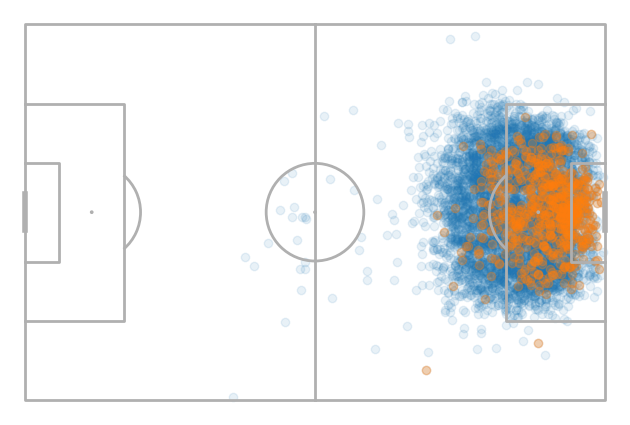

In [15]:
fig, ax = p.draw()
p.scatter(df_shots.x, df_shots.y, ax=ax, alpha=0.1)
p.scatter(df_shots[df_shots.goal].x, df_shots[df_shots.goal].y, ax=ax, alpha=0.3)

In [16]:
df_shots['goal'].mean()

0.11510914051841746

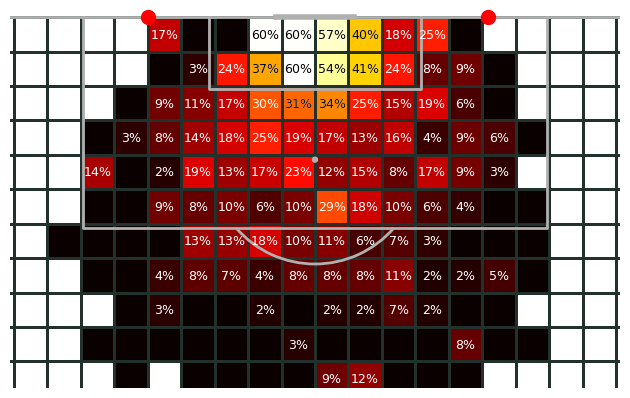

In [17]:
vp = VerticalPitch(pitch_type='opta', line_zorder=2, half=True,
                   pad_left=-12, pad_right=-12, pad_bottom=-31, pad_top=1)
fig, ax = vp.draw()
bs = vp.bin_statistic(df_shots['x'], df_shots['y'], df_shots['goal'], statistic='mean',
                      bins=(36, 24)
                     )
bs_count = vp.bin_statistic(df_shots['x'], df_shots['y'],
                            bins=(36, 24),
                           )
bs['statistic'][bs_count['statistic'] < 5] = np.nan
hm = vp.heatmap(bs, ax=ax, cmap='hot', edgecolors='#22312b')
hm_labels = vp.label_heatmap(bs, ax=ax, exclude_zeros=True, str_format='{:.0%}',
                             color='white', va='center', ha='center',
                             exclude_nan=True, fontsize=9)
bs['statistic'][bs['statistic'] < 0.3] = np.nan
hm_labels = vp.label_heatmap(bs, ax=ax, exclude_zeros=True,
                             str_format='{:.0%}', color='black', va='center', ha='center', exclude_nan=True,
                             fontsize=9)

vp.scatter(100, 70.82163636, s=100, zorder=10, c='red', ax=ax)
vp.scatter(100, 28.46472727, s=100, zorder=10, c='red', ax=ax)

In [18]:
opta_to_uefa = Standardizer(pitch_from='opta', pitch_to='uefa')
uefa_to_opta = Standardizer(pitch_from='uefa', pitch_to='opta')
y_coordinate = bs['y_grid'][7, 0]
new_x, new_y = opta_to_uefa.transform([100], [y_coordinate])
68/2 - new_y

array([-14.50819533])

In [19]:
_, new_pen_y = uefa_to_opta.transform([105, 105], [68/2 - 15, 68/2 + 15])

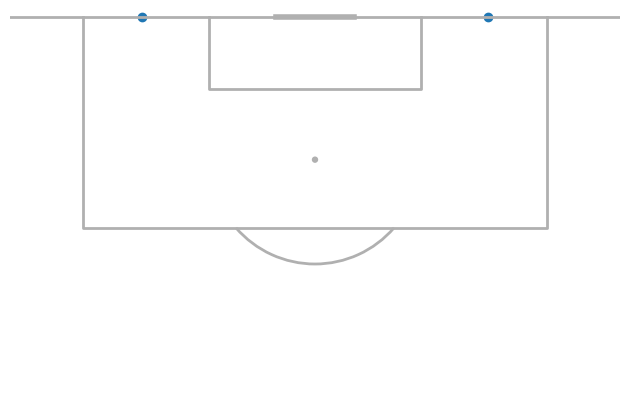

In [20]:
fig, ax = vp.draw()
vp.scatter([100, 100], new_pen_y, ax=ax)

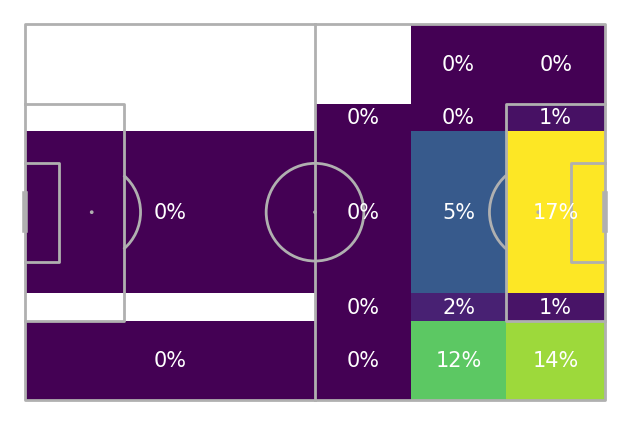

In [21]:
bins = (p.dim.positional_x[[0, 3, 4, 5, 6]], np.concatenate([p.dim.positional_y[0: 2], new_pen_y, p.dim.positional_y[-2:]]))
#bins = (10, 10)
fig, ax = p.draw()
bs = p.bin_statistic(df_shots.x, df_shots.y, df_shots.goal, statistic='mean', bins=bins)
p.heatmap(bs, ax=ax, zorder=0)
p.label_heatmap(bs, ax=ax, str_format='{:.0%}', exclude_nan=True, fontsize=15, color='white', va='center', ha='center');

In [22]:
df_actions = pd.read_parquet('opta_actions_112_2022.parquet')
df_actions['move'] = (df_actions['carry']) | (df_actions['pass'])
df_actions = df_actions[((df_actions['move']) | (df_actions['shot'])) & (df_actions['set_piece_taken'].isnull()) & (df_actions['own_goal'].isnull())].copy()

In [23]:
shot_probability = p.bin_statistic(df_actions['x'], df_actions['y'],
                                       values=df_actions['shot'],
                                       statistic='mean', bins=bins)
move_probability = p.bin_statistic(df_actions['x'], df_actions['y'], 
                                       values=df_actions['move'],
                                       statistic='mean', bins=bins)
goal_probability = p.bin_statistic(df_actions.loc[df_actions['shot'], 'x'],
                                       df_actions.loc[df_actions['shot'], 'y'],
                                       df_actions.loc[df_actions['shot'], 'goal'],
                                       statistic='mean', bins=bins)

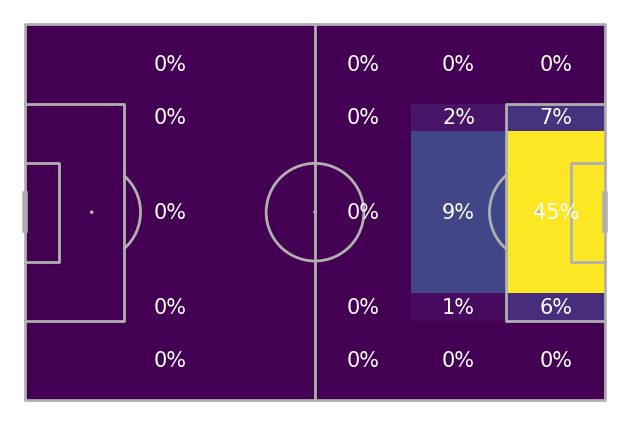

In [24]:
fig, ax = p.draw()
p.heatmap(shot_probability, ax=ax, zorder=0)
p.label_heatmap(shot_probability, ax=ax, str_format='{:.0%}', exclude_nan=True, fontsize=15, color='white', va='center', ha='center');

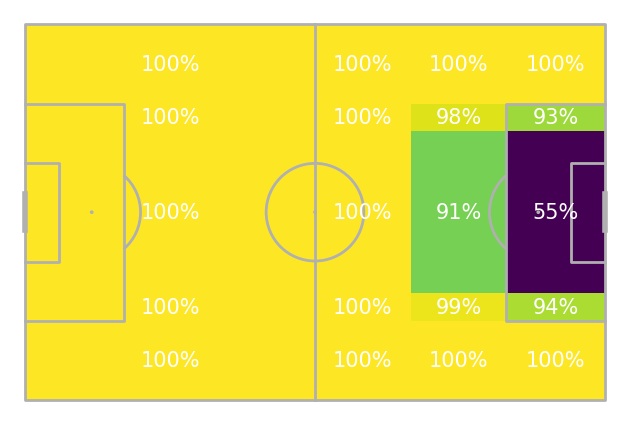

In [25]:
fig, ax = p.draw()
p.heatmap(move_probability, ax=ax, zorder=0)
p.label_heatmap(move_probability, ax=ax, str_format='{:.0%}', exclude_nan=True, fontsize=15, color='white', va='center', ha='center');

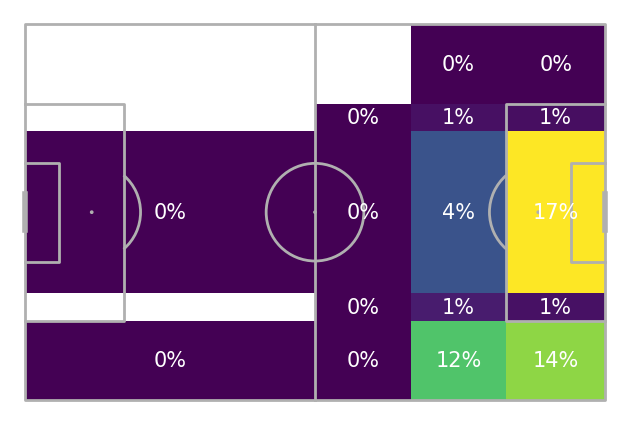

In [26]:
fig, ax = p.draw()
p.heatmap(goal_probability, ax=ax, zorder=0)
p.label_heatmap(goal_probability, ax=ax, str_format='{:.0%}', exclude_nan=True, fontsize=15, color='white', va='center', ha='center');

In [27]:
# get a dataframe of move events and filter it
# so the dataframe only contains actions inside the pitch.
move = df_actions[df_actions['move']].copy()
bin_start_locations = p.bin_statistic(move['x'], move['y'], bins=bins)
move = move[bin_start_locations['inside']].copy()

# get the successful moves, which filters out the events that ended outside the pitch
# or where not successful (null)
bin_end_locations = p.bin_statistic(move['end_x'], move['end_y'], bins=bins)
move_success = move[(bin_end_locations['inside']) & (move['outcome'] == 1)].copy()

# get a dataframe of the successful moves
# and the grid cells they started and ended in
bin_success_start = p.bin_statistic(move_success['x'], move_success['y'], bins=bins)
bin_success_end = p.bin_statistic(move_success['end_x'], move_success['end_y'], bins=bins)
df_bin = pd.DataFrame({'x': bin_success_start['binnumber'][0],
                       'y': bin_success_start['binnumber'][1],
                       'end_x': bin_success_end['binnumber'][0],
                       'end_y': bin_success_end['binnumber'][1]})

# calculate the bin counts for the successful moves, i.e. the number of moves between grid cells
bin_counts = df_bin.value_counts().reset_index(name='bin_counts')

# create the move_transition_matrix of shape (num_y_bins, num_x_bins, num_y_bins, num_x_bins)
# this is the number of successful moves between grid cells.
num_y, num_x = shot_probability['statistic'].shape
move_transition_matrix = np.zeros((num_y, num_x, num_y, num_x))
move_transition_matrix[bin_counts['y'], bin_counts['x'],
                       bin_counts['end_y'], bin_counts['end_x']] = bin_counts.bin_counts.values

# and divide by the starting locations for all moves (including unsuccessful)
# to get the probability of moving the ball successfully between grid cells
bin_start_locations = p.bin_statistic(move['x'], move['y'], bins=bins)
bin_start_locations = np.expand_dims(bin_start_locations['statistic'], (2, 3))
move_transition_matrix = np.divide(move_transition_matrix,
                                   bin_start_locations,
                                   out=np.zeros_like(move_transition_matrix),
                                   where=bin_start_locations != 0,
                                   )

In [28]:
move_transition_matrix = np.nan_to_num(move_transition_matrix)
shot_probability_matrix = np.nan_to_num(shot_probability['statistic'])
move_probability_matrix = np.nan_to_num(move_probability['statistic'])
goal_probability_matrix = np.nan_to_num(goal_probability['statistic'])

In [29]:
xt = np.multiply(shot_probability_matrix, goal_probability_matrix)
diff = 1
iteration = 0
while np.any(diff > 0.00001):  # iterate until the differences between the old and new xT is small
    xt_copy = xt.copy()  # keep a copy for comparing the differences
    # calculate the new expected threat
    xt = (np.multiply(shot_probability_matrix, goal_probability_matrix) +
          np.multiply(move_probability_matrix,
                      np.multiply(move_transition_matrix, np.expand_dims(xt, axis=(0, 1))).sum(
                          axis=(2, 3)))
          )
    diff = (xt - xt_copy)
    iteration += 1
print('Number of iterations:', iteration)

Number of iterations: 35


In [30]:
df_pen_shot['foul_wide_area'] = (df_pen_shot['y_foul'] < new_pen_y[0]) | (df_pen_shot['y_foul'] > new_pen_y[1])
df_pen_award['foul_wide_area'] = (df_pen_award['y'] < new_pen_y[0]) | (df_pen_award['y'] > new_pen_y[1])
df_pen_award.loc[df_pen_award['foul_wide_area'], ['foul_attempted_tackle', 'foul_handball', 'foul_shirt_pull_holding', 'foul_shove_push']].sum()

foul_attempted_tackle      21
foul_handball               8
foul_shirt_pull_holding     1
foul_shove_push             6
dtype: Int64

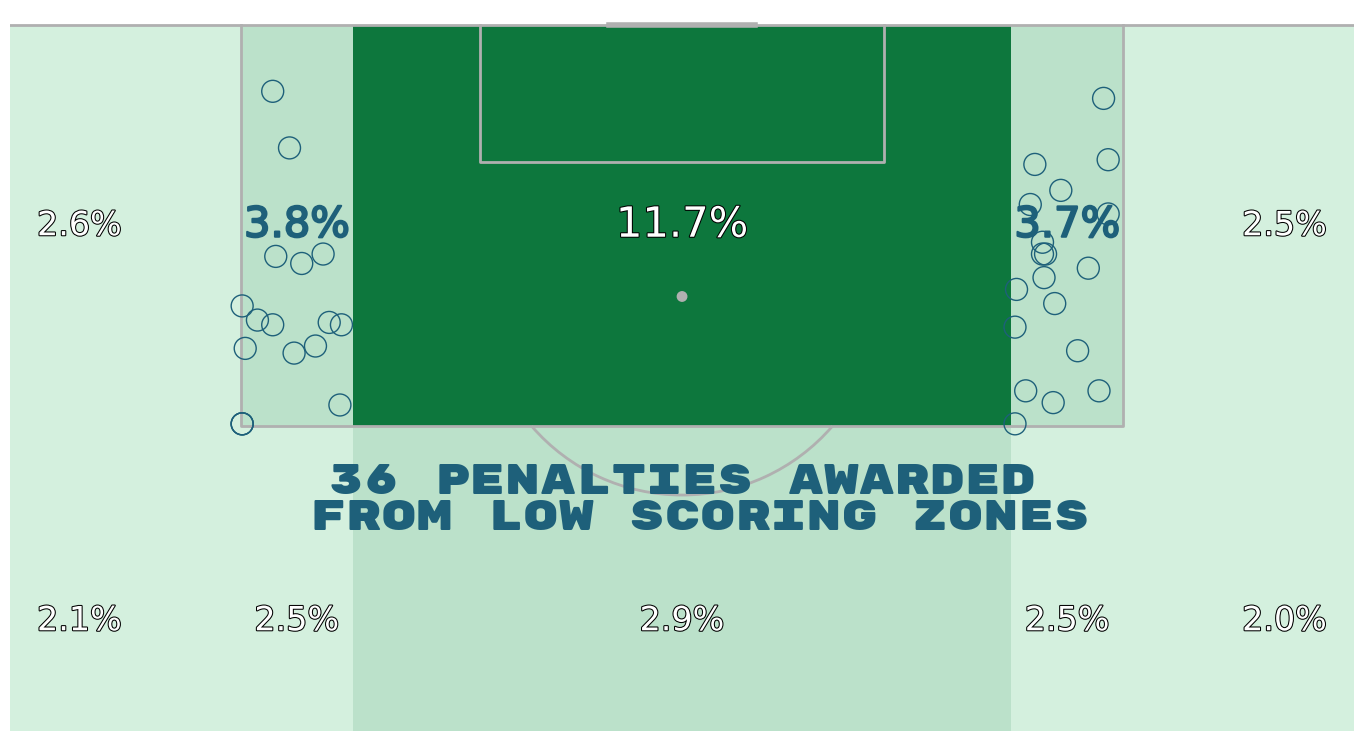

In [31]:
path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]
path_eff2 = [path_effects.Stroke(linewidth=1.5, foreground='#1E607A'),
            path_effects.Normal()]
fm_rubik = FontManager('https://raw.githubusercontent.com/google/fonts/main/ofl/'
                       'rubikmonoone/RubikMonoOne-Regular.ttf')

vp3 = VerticalPitch(pitch_type='opta', line_zorder=2, half=True,
                   pad_left=-6, pad_right=-6, pad_bottom=-31, pad_top=1)

# new bin statistic for plotting xt only
for_plotting = vp3.bin_statistic(df_actions['x'], df_actions['y'], bins=bins)
for_plotting['statistic'] = xt
fig, ax = vp3.draw(figsize=(14, 14/vp3.ax_aspect))
_ = vp3.heatmap(for_plotting, cmap=custom_cmap_10, ax=ax, zorder=1)
labels = vp3.label_heatmap(for_plotting, ax=ax, str_format='{:.1%}',
                           color='white', fontsize=24, va='center', ha='center',
                           path_effects=path_eff, zorder=3)
vp3.text(80, 50, f'{df_pen_award['foul_wide_area'].sum()} penalties awarded\n from low scoring zones', fontproperties=fm_rubik.prop, va='center', fontsize=30, color='#1E607A', ha='center', ax=ax)
for i, label in enumerate(labels):
    if i ==7 or i == 15:
        label.set_color('#1E607A')
        label.set_path_effects(path_eff2)
        label.set_fontsize(30)
    #elif i != 11:
    #    label.set_color('#1E607A')
    elif i == 11:
        label.set_fontsize(30)
vp3.scatter(df_pen_award[df_pen_award['foul_wide_area']].x, df_pen_award[df_pen_award['foul_wide_area']].y, s=250, ec='#1E607A', c='None', zorder=2, ax=ax)
fig.savefig('probability_scoring_wide_areas.png')

In [32]:
df_pen_shot['foul_wide_area'].sum()

36

In [33]:
len(df_match)

330

In [34]:
df_pen_shot[df_pen_shot['foul_wide_area']].match_id.nunique() / len(df_match)

0.10606060606060606

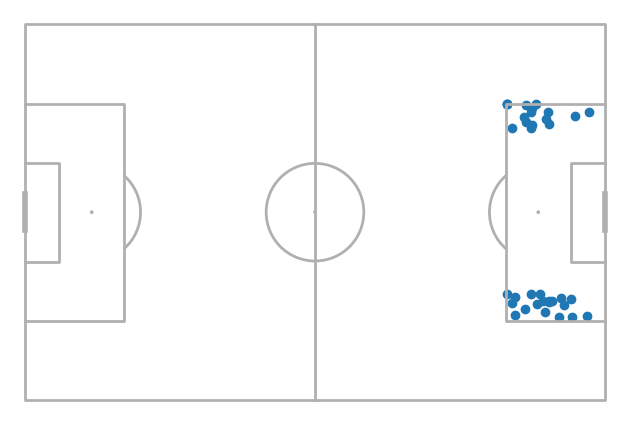

In [35]:
fig, ax = p.draw()
p.scatter(df_pen_shot.loc[df_pen_shot['foul_wide_area'], 'x_foul'],
          df_pen_shot.loc[df_pen_shot['foul_wide_area'], 'y_foul'],
          ax=ax)

In [36]:
df_actions.type_name.value_counts()

type_name
pass             276381
carry            224592
attempt_saved      3811
miss               2877
offside_pass       1194
goal                955
post                129
Name: count, dtype: int64

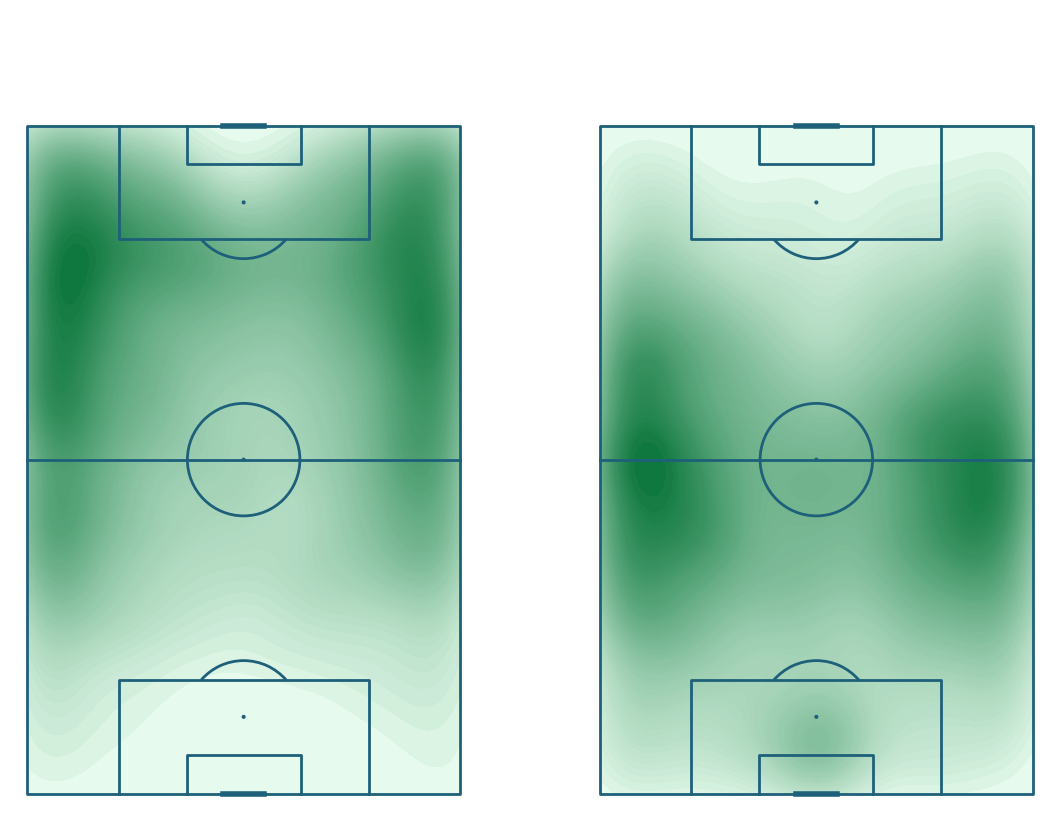

In [37]:
vp2 = VerticalPitch(pitch_type='opta', line_zorder=3, line_color='#1E607A')
green_cmap = LinearSegmentedColormap.from_list('greens', ['#edfff2', '#0d773d'], N=100)
grid_width, grid_height = vp2.grid_dimensions(figwidth=16, figheight=9, nrows=1, ncols=2, max_grid=0.65, space=0.15) # w, h
fig, ax = vp2.grid(ncols=2, grid_width=grid_width, grid_height=grid_height, endnote_height=0, title_height=0.1, bottom=0.03, space=0.15, axis=False)
df_tackle = df[(df.type_name == 'tackle')].copy()
df_foul = df[(df['type_name'] == 'foul') & (df.outcome == 1)].copy()
tackle_x, tackle_y = p.flip_side(df_tackle.x, df_tackle.y, [True] * len(df_tackle))
vp2.kdeplot(df_foul['x'], df_foul['y'], cmap=custom_cmap, fill=True, levels=100, zorder=1, thresh=0, ax=ax['pitch'][1])
#vp2.scatter(df_foul['x'], df_foul['y'], alpha=0.1, s=80, marker='o', zorder=2, ec='#1E607A', fc='None', ax=ax['pitch'][0])
vp2.kdeplot(tackle_x, tackle_y, cmap=custom_cmap, fill=True, levels=100, zorder=1, thresh=0, ax=ax['pitch'][0]) 
#vp2.scatter(tackle_x, tackle_y, alpha=0.1, s=80, marker='o', zorder=2, ec='#1E607A', fc='None', ax=ax['pitch'][1])
fig.savefig('unintended_consquences.png')

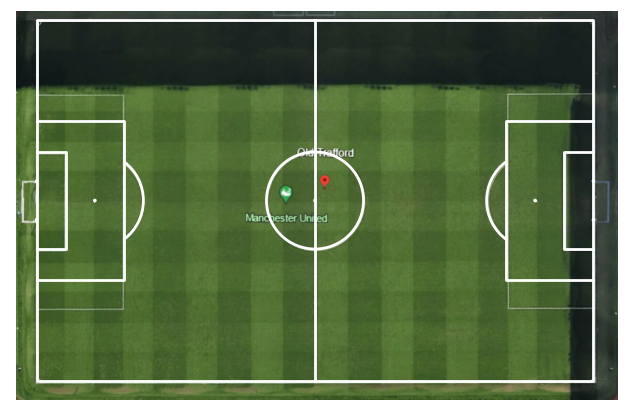

In [38]:
# picture of Old Trafford from Google Earth
hp = Pitch(pad_left=5, pad_bottom=2, pad_top=2, pad_right=5, pitch_type='uefa', line_zorder=2, pitch_color='None', line_color='white', linewidth=2, goal_type='circle')
hp.dim.penalty_area_top = 68/2 + 15
hp.dim.penalty_area_bottom = 68/2 - 15
hp.dim.penalty_area_width = 30 
fig, ax = hp.draw()
image = plt.imread('old_trafford_google_earth.png')
ax_image = add_image(image, fig, left=0.033, bottom=-0.01, width=0.94, height=1, alpha=1)
ax_image.set_zorder(1)
ax.set_zorder(2)
fig.savefig('old_trafford_new_lines.png', bbox_inches='tight', pad_inches=0)

In [39]:
mask_win_before = (((df_pen_shot['home_team']) & (df_pen_shot['home_score_before_penalty'] > df_pen_shot['away_score_before_penalty'])) |
                   ((~df_pen_shot['home_team']) & (df_pen_shot['home_score_before_penalty'] < df_pen_shot['away_score_before_penalty'])))
mask_draw_before = df_pen_shot['home_score_before_penalty'] == df_pen_shot['away_score_before_penalty']
df_pen_shot['state_before'] = 'L'
df_pen_shot.loc[mask_win_before, 'state_before'] = 'W'
df_pen_shot.loc[mask_draw_before, 'state_before'] = 'D'

In [40]:
mask_win_after = (((df_pen_shot['home_team']) & (df_pen_shot['home_score'] > df_pen_shot['away_score'])) |
                   ((~df_pen_shot['home_team']) & (df_pen_shot['home_score'] < df_pen_shot['away_score'])))
mask_draw_after = df_pen_shot['home_score'] == df_pen_shot['away_score']
df_pen_shot['state_after'] = 'L'
df_pen_shot.loc[mask_win_after, 'state_after'] = 'W'
df_pen_shot.loc[mask_draw_after, 'state_after'] = 'D'

In [41]:
mask_win_final = (((df_pen_shot['home_team']) & (df_pen_shot['home_score_final'] > df_pen_shot['away_score_final'])) |
                   ((~df_pen_shot['home_team']) & (df_pen_shot['home_score_final'] < df_pen_shot['away_score_final'])))
mask_draw_final = df_pen_shot['home_score_final'] == df_pen_shot['away_score_final']
df_pen_shot['state_final'] = 'L'
df_pen_shot.loc[mask_win_final, 'state_final'] = 'W'
df_pen_shot.loc[mask_draw_final, 'state_final'] = 'D'

In [42]:
mask_decisive = ((df_pen_shot['goal']) &
                 (df_pen_shot['state_before'].isin(['L', 'D'])) &
                 (df_pen_shot['state_final'].isin(['W', 'D'])) & 
                 (((df_pen_shot['away_score_final'] == df_pen_shot['away_score']) & (~df_pen_shot['home_team'])) | 
                  ((df_pen_shot['home_score_final'] == df_pen_shot['home_score']) & df_pen_shot['home_team'])
                 )
                )

In [43]:
((mask_decisive) & (df_pen_shot['foul_wide_area'])).sum() / len(df_match)                                                                                                                                                        

0.024242424242424242

In [44]:
df_pen_shot.loc[(df_pen_shot['foul_wide_area']) & (df_pen_shot['goal']), ['state_before', 'state_after', 'state_final']].value_counts()

state_before  state_after  state_final
W             W            W              10
D             W            W               8
L             D            D               4
                           W               3
D             W            D               2
L             L            L               2
              D            L               1
Name: count, dtype: int64

In [45]:
df_pen_shot.loc[(df_pen_shot['foul_wide_area']) & (df_pen_shot['goal']) & (df_pen_shot['state_after'] == 'D') & (df_pen_shot['state_final'] != 'L')].state_final.value_counts()

state_final
D    4
W    3
Name: count, dtype: int64

In [46]:
df_pen_shot.loc[(df_pen_shot['foul_wide_area']) & (df_pen_shot['goal']), 'state_final'].value_counts()

state_final
W    21
D     6
L     3
Name: count, dtype: int64

In [47]:
# percent of games affected
((df_pen_shot['foul_wide_area']) & (df_pen_shot['goal'])).sum() / len(df_match)

0.09090909090909091

In [48]:
(df_pen_shot.loc[(df_pen_shot['foul_wide_area']) & (df_pen_shot['goal']), 'state_final'] == 'W').mean()

0.7

In [49]:
final_state_counts = df_pen_shot.loc[(df_pen_shot['foul_wide_area']) & (df_pen_shot['goal']), 'state_final'].value_counts().sort_values()

In [50]:
labels = (final_state_counts.index + ' ' + round(final_state_counts / final_state_counts.sum() * 100, 0).astype(int).astype(str) + '%').tolist()

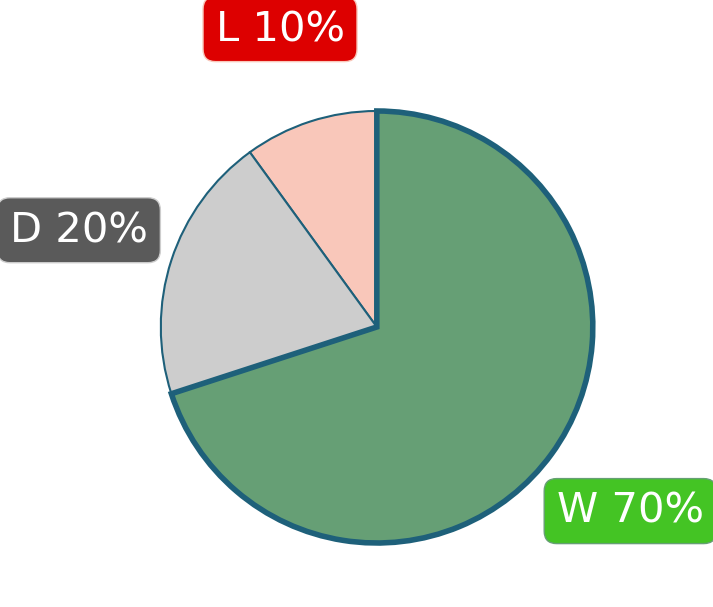

In [51]:
grid_width, grid_height = grid_dimensions(ax_aspect=1, figwidth=16, figheight=9, space=0.5,
                                          nrows=1, ncols=2, max_grid=0.6)
fig, ax = grid(grid_width=grid_width, grid_height=grid_height, figheight=9,
               title_height=0, endnote_height=0, space=0.5,
               ax_aspect=1, bottom=0.05, ncols=2)
ax[1].remove()
patches, text = ax[0].pie(final_state_counts,
                          startangle=90, colors=['#f9c7ba', '#cdcdcd', '#669f75'],
                          wedgeprops={'ec': '#1E607A', 'lw': 1.5},
                          textprops={'fontsize': 30, 'va': 'center', 'ha': 'center', 'color': 'white'},
                          labels=labels,
                          labeldistance=1.45
                         )
for t in text:
    if(t.get_text()[0] == 'W'):
        t.set_bbox(dict(boxstyle='round,pad=0.3', fc='#44c424', ec='#669f75'))
    if(t.get_text()[0] == 'D'):
        t.set_bbox(dict(boxstyle='round,pad=0.3', fc='#5a5a5a', ec='#cdcdcd'))
    if(t.get_text()[0] == 'L'):
        t.set_bbox(dict(boxstyle='round,pad=0.3', fc='#dd0000', ec='#f9c7ba'))

patches[-1].set_linewidth(4)
fig.savefig('win_percentages_penalty_scored_wide.png')